## 1. Download `Glove` dataset and `news20` dataset

In [0]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical # https://stackoverflow.com/a/43314437
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    

# Download glove data, unzip glove.6B.zip/glove.6B.100d.txt into glove.6B folder
# https://askubuntu.com/a/520555
!rm -rf ./*
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!mkdir glove.6B
!mv glove.6B.100d.txt ./glove.6B
!rm *.txt *.zip
# Download news20 data, unzip news20.tar.gz/
!wget http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz
!tar -xvzf news20.tar.gz
!rm *.tar.gz

In [2]:
!ls

20_newsgroup  glove.6B


## 2. Config dataset path

In [0]:
# config file path
BASE_DIR = './'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')

## 3. Preparing the text data

In [4]:
# first build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, 'f', sep=' ')
    embeddings_index[word] = coefs
    
print('Found %s word vectors.' % len(embeddings_index))



# Second, prepare text samples and their labels
print('Processing text dataset')
texts = [] # list of text samples
labels_index = {} # dictionary mapping label name to numeric id
labels = [] # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
  path = os.path.join(TEXT_DATA_DIR, name)
  if os.path.isdir(path):
    label_id = len(labels_index)
    labels_index[name] = label_id
    for fname in sorted(os.listdir(path)):
      if fname.isdigit():
        fpath = os.path.join(path, fname)
        args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
        with open(fpath, **args) as f:
          t = f.read()
          i = t.find('\n\n') # skip header
          if 0 < i:
            t = t[i:]
          texts.append(t)
        labels.append(label_id)
        
print('Found %s texts.' % len(texts))

Indexing word vectors.
Found 400000 word vectors.
Processing text dataset
Found 19997 texts.


## 4. Format text samples and labels

In [5]:


# config feature dimensions
MAX_SEQUENCE_LENGTH = 1000 # truncate the sequences to a maximum length of 1000
MAX_NUM_WORDS = 20000 # top 20,000 most commonly occuring words in the dataset
VALIDATION_SPLIT = 0.2

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Round %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

Round 174074 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)


## 5. Preparing the embedding layer

In [6]:
print('Preparing embedding matrix.')
EMBEDDING_DIM = 100

num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
  if i > MAX_NUM_WORDS:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zero.
    embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                           EMBEDDING_DIM,
                           embeddings_initializer=Constant(embedding_matrix),
                           input_length=MAX_SEQUENCE_LENGTH,
                           trainable=False)

Preparing embedding matrix.


## 6. Train model

Training model.
Train on 15998 samples, validate on 3999 samples
Epoch 1/10
15998/15998 [==============================] - 4s 225us/step - loss: 2.4422 - acc: 0.2001 - val_loss: 1.7430 - val_acc: 0.4049
Epoch 2/10
15998/15998 [==============================] - 3s 203us/step - loss: 1.5643 - acc: 0.4547 - val_loss: 1.2820 - val_acc: 0.5746
Epoch 3/10
15998/15998 [==============================] - 3s 203us/step - loss: 1.1818 - acc: 0.5954 - val_loss: 1.1611 - val_acc: 0.5964
Epoch 4/10
15998/15998 [==============================] - 3s 205us/step - loss: 0.9775 - acc: 0.6662 - val_loss: 1.0749 - val_acc: 0.6469
Epoch 5/10
15998/15998 [==============================] - 3s 204us/step - loss: 0.8209 - acc: 0.7193 - val_loss: 0.9912 - val_acc: 0.6874
Epoch 6/10
15998/15998 [==============================] - 3s 206us/step - loss: 0.6980 - acc: 0.7658 - val_loss: 0.9672 - val_acc: 0.6824
Epoch 7/10
15998/15998 [==============================] - 3s 208us/step - loss: 0.5938 - acc: 0.8000 - val_

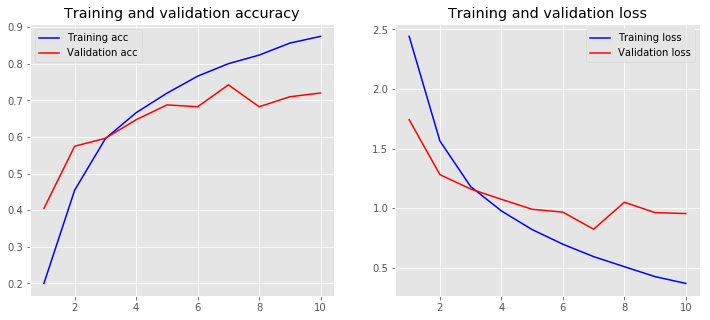

In [9]:
print('Training model.')
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print('Training Accuracy: {:.4f}'.format(accuracy))
loss, accuracy = model.evaluate(x_val, y_val, verbose=False)
print('Validation Accuracy: {:.4f}'.format(accuracy))

plot_history(history)

## 7. Predict

In [27]:
labels_index_2_labels_name = {labels_index[label]: label for label in labels_index}

def news_classifier(news_list):
  sequences = tokenizer.texts_to_sequences(news_list)
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
  predictions = model.predict(data)
  return predictions

news1 = "With strikeouts piling up, scoring plummeting, attendance falling and games often descending into all-or-nothing bores, it's no wonder that some people are calling for radical change to baseball. The sport faced a similar challenge 50 years ago, dogged by a scoring depression and lagging fan interest. In response, baseball's rules committee lowered the pitcher's mound 5 inches and tightened the strike zone, making it harder for pitchers to dominate the game. That sparked more scoring the next season — and more exciting games for fans."
news2 = "This week, scientists discovered the interstellar origins of a meteor that crashed into Earth in 2014, and DNA was extracted from the bones of 13th-century soldiers who fought in the Crusades. A NASA study determined that when meteorites strike the moon, they cause water plumes to shoot into space. The first molecule produced by the Big Bang has finally been found in space. And one of the largest carnivorous mammals to ever walk the Earth was discovered. NASA astronaut Christina Koch is also aiming to hold the record for longest single spaceflight by a woman. Here's what you missed this week in space and science"
news3 = "It looks like a Bluetooth hands-free device, but bitescan is actually measuring your chewing strokes as you eat. Hung from the ear, it is smaller and lighter than existing bite counters (they're normally attached to the chin) and can determine a user's bite speed, number of bites per minute and type of bite using a waveform detected on the back of the ear. Sharp has somewhat gamified the concept: the device syncs up to a smartphone app which categorizes results by animal type i.e. slow chewers are tortoises."

news_list_test = [news1, news2, news3]

predictions = news_classifier(news_list_test)
news_list_test_predictions = [labels_index_2_labels_name[np.argmax(prob)] for prob in predictions]
print(news_list_test_predictions)


['rec.sport.baseball', 'sci.space', 'sci.med']


## 8. Save to local

In [0]:
model.save('news_classifier_v1.h5')

In [0]:
from google.colab import files
files.download('news_classifier_v1.h5')

